In [1]:
import json
from pathlib import Path
import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd

import hashlib

from rich.progress import track
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay, precision_recall_fscore_support, accuracy_score, balanced_accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MaxAbsScaler

# Load data from the cross validations

In [2]:
def parse_files(root_path):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = root_path.joinpath("cross-validations").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = root_path.joinpath(data["original_target"])
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data])

    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    return results


data_flattened = parse_files(Path("./analysis/paper-data"))
data_flattened

Output()

C  alpha hidden_layer_sizes  kernel  \
percentage model use_gradient use_ewma                                          
19         DT    False        False     NaN    NaN                NaN     NaN   
                              False     NaN    NaN                NaN     NaN   
                              False     NaN    NaN                NaN     NaN   
                              False     NaN    NaN                NaN     NaN   
                              False     NaN    NaN                NaN     NaN   
...                                     ...    ...                ...     ...   
15         SVM   True         True      0.1    NaN                NaN  linear   
                              True      0.1    NaN                NaN  linear   
                              True      0.1    NaN                NaN  linear   
                              True      0.1    NaN                NaN  linear   
                              True      0.1    NaN                NaN  linear   

                                        learning_rate max_depth  n_estimators  \
percentage model use_gradient use_ewma                                          
19         DT    False        False               NaN      None           NaN   
                              False               NaN      None           NaN   
                              False               NaN      None           NaN   
                              False               NaN      None           NaN   
                              False               NaN      None           NaN   
...                                               ...       ...           ...   
15         SVM   True         True                NaN       NaN           NaN   
                              True                NaN       NaN           NaN   
                              True                NaN       NaN           NaN   
                              True                NaN       NaN           NaN   
                              True                NaN       NaN           NaN   

                                        f1_score  \
percentage model use_gradient use_ewma             
19         DT    False        False     0.800000   
                              False     0.761905   
                              False     0.266667   
                              False     0.608696   
                              False     0.600000   
...                                          ...   
15         SVM   True         True      0.769231   
                              True      0.583333   
                              True      0.692308   
                              True      0.521739   
                              True      0.727273   

                                                                               model_path  
percentage model use_gradient use_ewma                                                     
19         DT    False        False     paper-data/cross-validations/DT_19_no-grad_no-...  
                              False     paper-data/cross-validations/DT_19_no-grad_no-...  
                              False     paper-data/cross-validations/DT_19_no-grad_no-...  
                              False     paper-data/cross-validations/DT_19_no-grad_no-...  
                              False     paper-data/cross-validations/DT_19_no-grad_no-...  
...                                                                                   ...  
15         SVM   True         True      paper-data/cross-validations/SVM_15_grad_ewma_...  
                              True      paper-data/cross-validations/SVM_15_grad_ewma_...  
                              True      paper-data/cross-validations/SVM_15_grad_ewma_...  
                              True      paper-data/cross-validations/SVM_15_grad_ewma_...  
                              True      paper-data/cross-validations/SVM_15_grad_ewma_...  

[33540 rows x 9 columns]

This data contains the hyperparameters of models, along with paths to their original settings and the f1 score over multiple folds for each percentage.

## Best and worst hyperparameters per model

Now, we'll look at the best and worst hyperparameters per model, in order to do a fair comparison.

In [3]:
# Remove any runs that included use_ewma or use_gradient
data = data_flattened.loc[(slice(None), slice(None), False, False), :]
data.index = data.index.droplevel([2, 3])
data = data.sort_values(by=['percentage', 'model'])
data

C  alpha hidden_layer_sizes  kernel  learning_rate  \
percentage model                                                            
1          AdaBoost  NaN    NaN                NaN     NaN            1.0   
           AdaBoost  NaN    NaN                NaN     NaN            1.0   
           AdaBoost  NaN    NaN                NaN     NaN            1.0   
           AdaBoost  NaN    NaN                NaN     NaN            1.0   
           AdaBoost  NaN    NaN                NaN     NaN            1.0   
...                  ...    ...                ...     ...            ...   
20         SVM       1.0    NaN                NaN  linear            NaN   
           SVM       1.0    NaN                NaN  linear            NaN   
           SVM       1.0    NaN                NaN  linear            NaN   
           SVM       1.0    NaN                NaN  linear            NaN   
           SVM       1.0    NaN                NaN  linear            NaN   

                    max_depth  n_estimators  f1_score  \
percentage model                                        
1          AdaBoost       NaN         100.0  0.862385   
           AdaBoost       NaN         100.0  0.892857   
           AdaBoost       NaN         100.0  0.884615   
           AdaBoost       NaN         100.0  0.912621   
           AdaBoost       NaN         100.0  0.895238   
...                       ...           ...       ...   
20         SVM            NaN           NaN  0.588235   
           SVM            NaN           NaN  0.555556   
           SVM            NaN           NaN  0.631579   
           SVM            NaN           NaN  0.695652   
           SVM            NaN           NaN  0.631579   

                                                            model_path  
percentage model                                                        
1          AdaBoost  paper-data/cross-validations/AdaBoost_1_no-gra...  
           AdaBoost  paper-data/cross-validations/AdaBoost_1_no-gra...  
           AdaBoost  paper-data/cross-validations/AdaBoost_1_no-gra...  
           AdaBoost  paper-data/cross-validations/AdaBoost_1_no-gra...  
           AdaBoost  paper-data/cross-validations/AdaBoost_1_no-gra...  
...                                                                ...  
20         SVM       paper-data/cross-validations/SVM_20_no-grad_no...  
           SVM       paper-data/cross-validations/SVM_20_no-grad_no...  
           SVM       paper-data/cross-validations/SVM_20_no-grad_no...  
           SVM       paper-data/cross-validations/SVM_20_no-grad_no...  
           SVM       paper-data/cross-validations/SVM_20_no-grad_no...  

[8600 rows x 9 columns]

In [4]:
def float_or_list_to_tuple(x):
    if isinstance(x, list):
        return tuple(x)
    return x

data["hidden_layer_sizes"] = data['hidden_layer_sizes'].apply(float_or_list_to_tuple)

In [5]:
group = data.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha'], dropna=False)
summary = group['f1_score'].agg(['mean', 'std'])

idx = summary.groupby(['percentage', 'model']).idxmax()

best_hyperparams = summary.loc[idx['mean'], :]
best_per_percentage = best_hyperparams.groupby('percentage')['mean'].idxmax()
selected_percentages = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin([1, 5, 10, 15, 20]) & best_hyperparams.index.get_level_values('model').isin(['RF', 'ET', 'DT', 'AdaBoost'])]
models_to_test = selected_percentages.droplevel(['C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'alpha'])
models_to_test


mean       std
percentage model    max_depth n_estimators                    
1          AdaBoost NaN       200.0         0.890519  0.049528
           DT       NaN       NaN           0.890533  0.026579
           ET       20.0      50.0          0.918597  0.032841
           RF       20.0      100.0         0.922107  0.034108
5          AdaBoost NaN       200.0         0.814197  0.065646
           DT       NaN       NaN           0.811702  0.048173
           ET       NaN       50.0          0.870902  0.032565
           RF       NaN       200.0         0.868601  0.040746
10         AdaBoost NaN       200.0         0.770268  0.075186
           DT       10.0      NaN           0.742989  0.087560
           ET       NaN       50.0          0.811445  0.062960
           RF       NaN       100.0         0.800145  0.091125
15         AdaBoost NaN       200.0         0.704556  0.101312
           DT       10.0      NaN           0.674766  0.100104
           ET       NaN       100.0         0.740676  0.106452
           RF       NaN       50.0          0.719174  0.078037
20         AdaBoost NaN       200.0         0.692862  0.081980
           DT       10.0      NaN           0.588552  0.087479
           ET       10.0      50.0          0.654424  0.131961
           RF       20.0      50.0          0.638096  0.097564

In [6]:
random_state = 42
classifiers = {}
for percentage, model, max_depth, n_estimators in models_to_test.index:
    if np.isnan(max_depth):
        max_depth = None
    else:
        max_depth = int(max_depth)
    if model != 'DT':
        n_estimators = int(n_estimators)
    if model == 'ET':
        classifiers[(percentage, model)] = ExtraTreesClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced')
    elif model == 'RF':
        classifiers[(percentage, model)] = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=random_state, class_weight='balanced_subsample')
    elif model == 'DT':
        classifiers[(percentage, model)] = DecisionTreeClassifier(max_depth=max_depth, random_state=random_state, class_weight='balanced')
    classifiers[(percentage, 'Dum')] = DummyClassifier(strategy='stratified', random_state=random_state)
classifiers

{(1, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (1, 'DT'): DecisionTreeClassifier(class_weight='balanced', random_state=42),
 (1,
  'ET'): ExtraTreesClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                      random_state=42),
 (1,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        random_state=42),
 (5, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (5, 'DT'): DecisionTreeClassifier(class_weight='balanced', random_state=42),
 (5,
  'ET'): ExtraTreesClassifier(class_weight='balanced', n_estimators=50, random_state=42),
 (5,
  'RF'): RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                        random_state=42),
 (10, 'Dum'): DummyClassifier(random_state=42, strategy='stratified'),
 (10,
  'DT'): DecisionTreeClassifier(class_weight='balanced', max_depth=10, random_state=42),
 (10,
  'ET'): ExtraTreesClassifier(class_weight='ba

In [7]:
def preprocess(dataframe, scaler=None):
    result, mzn = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)

    if scaler is None:
        result = result.drop(result.columns[result.nunique() == 1], axis=1)
        scaler = MaxAbsScaler().fit(result)
    else:
        # Drop constant columns except those in scaler.feature_names_in_
        constant_columns = result.columns[result.nunique() == 1]
        features_in = scaler.feature_names_in_
        columns_to_drop = constant_columns.difference(features_in)
        result = result.drop(columns=columns_to_drop, axis=1)
        
        
    result = pd.DataFrame(scaler.transform(result), columns=result.columns, index=result.index)

    result['mzn'] = mzn

    return result, scaler

In [8]:
import pickle 
scalers = {}
train_pkl = Path('./analysis/paper-data/features_with_fixed_log_calcs.pickle_train.pkl')
with open(train_pkl, 'rb') as f:
    train_features_at_percentage = pickle.load(f)
    

for percentage, model in classifiers:
    print(f"Training {model} at {percentage}%")
    df, scaler = preprocess(train_features_at_percentage[percentage])
    scalers[(percentage, model)] = scaler
    df = df.drop(columns=['mzn'], axis=1)
    any_nan = df.isna().any().any()
    
    if any_nan:
        print("The NaN values are in the following columns:")
        print(df.columns[df.isna().any()])
    else:
        train_X, train_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        print(train_y.value_counts(normalize=False))
        classifiers[(percentage, model)].fit(train_X, train_y)

Training Dum at 1%
solved_within_time_limit
1.0    523
0.0    443
Name: count, dtype: int64
Training DT at 1%
solved_within_time_limit
1.0    523
0.0    443
Name: count, dtype: int64
Training ET at 1%
solved_within_time_limit
1.0    523
0.0    443
Name: count, dtype: int64
Training RF at 1%
solved_within_time_limit
1.0    523
0.0    443
Name: count, dtype: int64
Training Dum at 5%
solved_within_time_limit
0.0    441
1.0    290
Name: count, dtype: int64
Training DT at 5%
solved_within_time_limit
0.0    441
1.0    290
Name: count, dtype: int64
Training ET at 5%
solved_within_time_limit
0.0    441
1.0    290
Name: count, dtype: int64
Training RF at 5%
solved_within_time_limit
0.0    441
1.0    290
Name: count, dtype: int64
Training Dum at 10%
solved_within_time_limit
0.0    442
1.0    179
Name: count, dtype: int64
Training DT at 10%
solved_within_time_limit
0.0    442
1.0    179
Name: count, dtype: int64
Training ET at 10%
solved_within_time_limit
0.0    442
1.0    179
Name: count, dtype:

In [9]:
describe_features = pd.DataFrame({'feature': preprocess(train_features_at_percentage[1])[0].drop(['mzn', 'solved_within_time_limit'], axis=1).columns})
describe_features['description'] = [
'conflicts',
 'decisions',
 'search_iterations',
 'opennodes',
 'vars',
 'back_jumps',
 'solutions',
 'total_time',
 'search_time',
 'intVars',
 'propagations',
 'sat_propagations',
 'propagators',
 'boolVars',
 'learnt',
 'bin',
 'tern',
 'long',
 'peak_depth',
 'decision_level_engine',
 'decision_level_treesize',
 'clause_mem',
 'prop_mem',
 'log_of_unassn_var',
 'frac_prop_vars',
 'freq_backjumps',
 'frac_bool_vars',
 'frac_long_clauses',
 'log_of_frac_unassign_var',
 'log_of_fraction_of_failures_versus_unassigned']
describe_features['translated'] = [
    False
] * 30
describe_features

,feature,description,translated
0,conflicts,conflicts,False
1,decisions,decisions,False
2,search_iterations,search_iterations,False
3,opennodes,opennodes,False
4,vars,vars,False
5,back_jumps,back_jumps,False
6,solutions,solutions,False
7,total_time,total_time,False
8,search_time,search_time,False
9,intVars,intVars,False


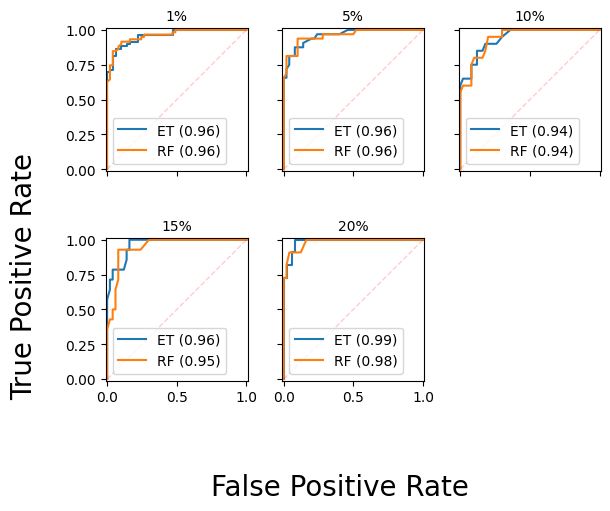

In [10]:
test_pickle = Path('./analysis/paper-data/features_with_fixed_log_calcs.pickle_test.pkl')

with open(test_pickle, 'rb') as f:
    test_features_at_percentage = pickle.load(f)

fig, ax = plt.subplots(2, 3, figsize=(6, 5), sharex=True, sharey=True)

fig.subplots_adjust(hspace=0.1, wspace=0.3)
ax = ax.flatten()
scores = []

for i, percentage in enumerate([1, 5, 10, 15, 20]):
    for model in ['ET', 'RF', 'DUM']:
        scaler = scalers[(percentage, model)]
        df, _ = preprocess(test_features_at_percentage[percentage], scaler)
        df = df.drop(columns=['mzn'], axis=1)
        
        test_X, test_y = df.drop(columns=['solved_within_time_limit']), df['solved_within_time_limit']
        
        y_score = classifiers[(percentage, model)].predict_proba(test_X)[:, 1]
        if model != 'Dum':
            display = RocCurveDisplay.from_predictions(test_y, y_score, ax=ax[i], name=model)
            line = display.line_
            display.line_.set_label(line.get_label().replace('AUC = ', ''))
            ax[i].legend()
            ax[i].set_xlabel('')
            ax[i].set_ylabel('')

        prec, rec, score, support = precision_recall_fscore_support(test_y, classifiers[(percentage, model)].predict(test_X), average='binary', pos_label=False)
        accuracy = accuracy_score(test_y, classifiers[(percentage, model)].predict(test_X))
        balanced_accuracy = balanced_accuracy_score(test_y, classifiers[(percentage, model)].predict(test_X))
        # print(f"For {model} at {percentage}%, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {score:.2f}")
        
        scores.append([percentage, model, accuracy, balanced_accuracy, prec, rec, score])

    ax[i].set_title(f"{percentage}%", fontsize=10)
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=1, color='r', alpha=.2)
            

fig.supxlabel('False Positive Rate', fontsize=20, y=-0.05, x=0.54)
fig.supylabel('True Positive Rate', fontsize=20, x=-0.01, y=0.4)
ax[5].set_axis_off()
fig.tight_layout()

# tikzplotlib.clean_figure(fig)
# tikzplotlib.save("roc_curves.tex", axis_width="0.36\\textwidth", axis_height="0.36\\textwidth")